In [1]:
import pandas as pd

data = pd.read_csv('labeled_data.csv')
texts = data['text'].tolist()
labels = data['label'].tolist()


In [2]:
from torch.utils.data import Dataset

class LegalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [89]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Adjust num_labels as needed


e:\anaconda\envs\chatbot_new\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
dataset = LegalDataset(texts, labels, tokenizer, max_length=128)


In [91]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)


e:\anaconda\envs\chatbot_new\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [92]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, model.config.num_labels), inputs['labels'].view(-1))
        return (loss, outputs) if return_outputs else loss

In [93]:
import torch

In [94]:
from sklearn.model_selection import train_test_split

train_texts, eval_texts, train_labels, eval_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [95]:
eval_dataset = LegalDataset(eval_texts, eval_labels, tokenizer, max_length=128)


In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl

class LossLoggerCallback(TrainerCallback):
    def on_log(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        if 'loss' in state.log_history[-1]:
            train_losses.append(state.log_history[-1]['loss'])

train_losses = []
eval_losses = []




# Custom function to compute precision, recall, and F1 score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {'precision': precision, 'recall': recall, 'f1': f1}

In [97]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[LossLoggerCallback]
)

trainer.train()


 20%|██        | 1/5 [00:00<00:01,  2.40it/s]

{'eval_loss': 0.6250817179679871, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0302, 'eval_samples_per_second': 33.086, 'eval_steps_per_second': 33.086, 'epoch': 1.0}


 40%|████      | 2/5 [00:00<00:01,  2.42it/s]

{'eval_loss': 0.5806429982185364, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0332, 'eval_samples_per_second': 30.16, 'eval_steps_per_second': 30.16, 'epoch': 2.0}


 60%|██████    | 3/5 [00:01<00:00,  2.52it/s]

{'eval_loss': 0.5466485023498535, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0302, 'eval_samples_per_second': 33.155, 'eval_steps_per_second': 33.155, 'epoch': 3.0}


 80%|████████  | 4/5 [00:01<00:00,  2.61it/s]

{'eval_loss': 0.5239527225494385, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0319, 'eval_samples_per_second': 31.357, 'eval_steps_per_second': 31.357, 'epoch': 4.0}


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

{'eval_loss': 0.5126144886016846, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0303, 'eval_samples_per_second': 32.99, 'eval_steps_per_second': 32.99, 'epoch': 5.0}
{'train_runtime': 2.3917, 'train_samples_per_second': 8.362, 'train_steps_per_second': 2.091, 'train_loss': 0.5962993621826171, 'epoch': 5.0}


TrainOutput(global_step=5, training_loss=0.5962993621826171, metrics={'train_runtime': 2.3917, 'train_samples_per_second': 8.362, 'train_steps_per_second': 2.091, 'total_flos': 165829048320.0, 'train_loss': 0.5962993621826171, 'epoch': 5.0})

In [98]:
# Custom training loop to log training loss
for epoch in range(int(training_args.num_train_epochs)):
    trainer.train()
    
    # Evaluate the model and log validation loss
    results = trainer.evaluate()
    eval_loss = results['eval_loss']
    eval_losses.append(eval_loss)

 20%|██        | 1/5 [00:00<00:01,  3.07it/s]

{'eval_loss': 0.45877698063850403, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.024, 'eval_samples_per_second': 41.601, 'eval_steps_per_second': 41.601, 'epoch': 1.0}


 40%|████      | 2/5 [00:00<00:01,  2.84it/s]

{'eval_loss': 0.41970929503440857, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.03, 'eval_samples_per_second': 33.295, 'eval_steps_per_second': 33.295, 'epoch': 2.0}


 60%|██████    | 3/5 [00:01<00:00,  2.83it/s]

{'eval_loss': 0.3925214111804962, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.035, 'eval_samples_per_second': 28.602, 'eval_steps_per_second': 28.602, 'epoch': 3.0}


 80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

{'eval_loss': 0.3748767077922821, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.03, 'eval_samples_per_second': 33.287, 'eval_steps_per_second': 33.287, 'epoch': 4.0}


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


{'eval_loss': 0.3660525679588318, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0282, 'eval_samples_per_second': 35.471, 'eval_steps_per_second': 35.471, 'epoch': 5.0}
{'train_runtime': 2.2158, 'train_samples_per_second': 9.026, 'train_steps_per_second': 2.257, 'train_loss': 0.4467345714569092, 'epoch': 5.0}


 20%|██        | 1/5 [00:00<00:01,  3.03it/s]

{'eval_loss': 0.3251200020313263, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0301, 'eval_samples_per_second': 33.203, 'eval_steps_per_second': 33.203, 'epoch': 1.0}


 40%|████      | 2/5 [00:00<00:01,  2.85it/s]

{'eval_loss': 0.2967596650123596, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0252, 'eval_samples_per_second': 39.708, 'eval_steps_per_second': 39.708, 'epoch': 2.0}


 60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

{'eval_loss': 0.2774196267127991, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0303, 'eval_samples_per_second': 33.0, 'eval_steps_per_second': 33.0, 'epoch': 3.0}


 80%|████████  | 4/5 [00:01<00:00,  2.74it/s]

{'eval_loss': 0.2654050290584564, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0307, 'eval_samples_per_second': 32.531, 'eval_steps_per_second': 32.531, 'epoch': 4.0}


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


{'eval_loss': 0.2593134939670563, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0271, 'eval_samples_per_second': 36.923, 'eval_steps_per_second': 36.923, 'epoch': 5.0}
{'train_runtime': 2.2509, 'train_samples_per_second': 8.885, 'train_steps_per_second': 2.221, 'train_loss': 0.3231325387954712, 'epoch': 5.0}


 20%|██        | 1/5 [00:00<00:01,  2.83it/s]

{'eval_loss': 0.22970452904701233, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0342, 'eval_samples_per_second': 29.282, 'eval_steps_per_second': 29.282, 'epoch': 1.0}


 40%|████      | 2/5 [00:00<00:01,  2.72it/s]

{'eval_loss': 0.20900890231132507, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0329, 'eval_samples_per_second': 30.358, 'eval_steps_per_second': 30.358, 'epoch': 2.0}


 60%|██████    | 3/5 [00:01<00:00,  2.56it/s]

{'eval_loss': 0.19541940093040466, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.03, 'eval_samples_per_second': 33.333, 'eval_steps_per_second': 33.333, 'epoch': 3.0}


 80%|████████  | 4/5 [00:01<00:00,  2.53it/s]

{'eval_loss': 0.1869005560874939, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0358, 'eval_samples_per_second': 27.915, 'eval_steps_per_second': 27.915, 'epoch': 4.0}


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


{'eval_loss': 0.18298150599002838, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0335, 'eval_samples_per_second': 29.842, 'eval_steps_per_second': 29.842, 'epoch': 5.0}
{'train_runtime': 2.4121, 'train_samples_per_second': 8.291, 'train_steps_per_second': 2.073, 'train_loss': 0.23469192981719972, 'epoch': 5.0}


 20%|██        | 1/5 [00:00<00:01,  3.20it/s]

{'eval_loss': 0.16586710512638092, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0286, 'eval_samples_per_second': 34.923, 'eval_steps_per_second': 34.923, 'epoch': 1.0}


 40%|████      | 2/5 [00:00<00:01,  2.84it/s]

{'eval_loss': 0.1526423692703247, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.03, 'eval_samples_per_second': 33.3, 'eval_steps_per_second': 33.3, 'epoch': 2.0}


 60%|██████    | 3/5 [00:01<00:00,  2.72it/s]

{'eval_loss': 0.14201347529888153, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.034, 'eval_samples_per_second': 29.378, 'eval_steps_per_second': 29.378, 'epoch': 3.0}


 80%|████████  | 4/5 [00:01<00:00,  2.61it/s]

{'eval_loss': 0.1355932503938675, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0329, 'eval_samples_per_second': 30.415, 'eval_steps_per_second': 30.415, 'epoch': 4.0}


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


{'eval_loss': 0.1327003836631775, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0188, 'eval_samples_per_second': 53.082, 'eval_steps_per_second': 53.082, 'epoch': 5.0}
{'train_runtime': 2.3215, 'train_samples_per_second': 8.615, 'train_steps_per_second': 2.154, 'train_loss': 0.1731129765510559, 'epoch': 5.0}


 20%|██        | 1/5 [00:00<00:01,  2.96it/s]

{'eval_loss': 0.12002832442522049, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0358, 'eval_samples_per_second': 27.9, 'eval_steps_per_second': 27.9, 'epoch': 1.0}


 40%|████      | 2/5 [00:00<00:01,  2.76it/s]

{'eval_loss': 0.11037763208150864, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.031, 'eval_samples_per_second': 32.266, 'eval_steps_per_second': 32.266, 'epoch': 2.0}


 60%|██████    | 3/5 [00:01<00:00,  2.70it/s]

{'eval_loss': 0.10415863990783691, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0343, 'eval_samples_per_second': 29.162, 'eval_steps_per_second': 29.162, 'epoch': 3.0}


 80%|████████  | 4/5 [00:01<00:00,  2.66it/s]

{'eval_loss': 0.10074317455291748, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.035, 'eval_samples_per_second': 28.573, 'eval_steps_per_second': 28.573, 'epoch': 4.0}


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


{'eval_loss': 0.09910327941179276, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.0334, 'eval_samples_per_second': 29.898, 'eval_steps_per_second': 29.898, 'epoch': 5.0}
{'train_runtime': 2.3277, 'train_samples_per_second': 8.592, 'train_steps_per_second': 2.148, 'train_loss': 0.12913291454315184, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 114.54it/s]


In [99]:
# results = trainer.evaluate()
# print(results)


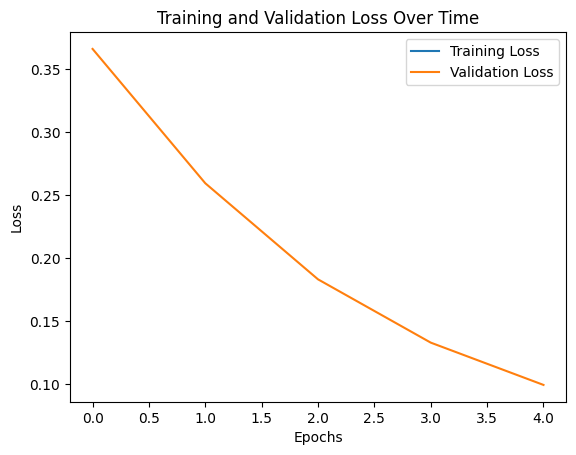

In [100]:
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

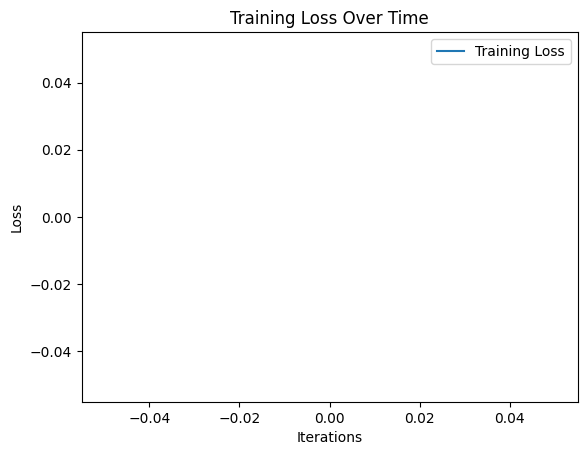

In [101]:
training_loss = trainer.state.log_history
loss_values = [x['loss'] for x in training_loss if 'loss' in x]
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [102]:
model.save_pretrained('D:\SIH_24\working\mode_save')

SafetensorError: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "The requested operation cannot be performed on a file with a user-mapped section open." })

In [75]:
tokenizer.save_pretrained(r'D:\SIH_24\working\tokenizer_save')

('D:\\SIH_24\\working\\tokenizer_save\\tokenizer_config.json',
 'D:\\SIH_24\\working\\tokenizer_save\\special_tokens_map.json',
 'D:\\SIH_24\\working\\tokenizer_save\\vocab.txt',
 'D:\\SIH_24\\working\\tokenizer_save\\added_tokens.json',
 'D:\\SIH_24\\working\\tokenizer_save\\tokenizer.json')

In [85]:
from transformers import BertForSequenceClassification, AutoTokenizer

model = BertForSequenceClassification.from_pretrained(r'D:\SIH_24\working\mode_save')
tokenizer = AutoTokenizer.from_pretrained(r'D:\SIH_24\working\tokenizer_save')


In [86]:
model.push_to_hub("shashaaa/fine_tune_embedd_SIH")
tokenizer.push_to_hub("shashaaa/fine_tune_embedd_SIH")

model.safetensors: 100%|██████████| 90.9M/90.9M [00:21<00:00, 4.23MB/s]
e:\anaconda\envs\chatbot_new\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shash\.cache\huggingface\hub\models--shashaaa--fine_tune_embedd_SIH. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/shashaaa/fine_tune_embedd_SIH/commit/4d436bd1339350f6cb51f166353b42812c5bf018', commit_message='Upload tokenizer', commit_description='', oid='4d436bd1339350f6cb51f166353b42812c5bf018', pr_url=None, pr_revision=None, pr_num=None)